<h1 style='color:blue' align='center'>Data Science Classification Project: Classifying Sprint Stacking Style in Tetr.io </h1>

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import pickle
import requests

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

**To get this information, a sample of users was first grabbed from the tetra league leaderboard api and then each of these user's sprint pbs was then grabbed using the player api. I then manually reviewed the replay and classified their sprint style. More information can be found in the Sprint Data Collection Notebook**

In [2]:
df = pd.read_csv("collected_sprint_data.csv")

In [3]:
df.head()

,seed,lines,inputs,holds,score,combo,topcombo,btb,topbtb,tspins,piecesplaced,finalTime,clears.singles,clears.doubles,clears.triples,clears.quads,clears.realtspins,clears.minitspins,clears.minitspinsingles,clears.tspinsingles,clears.tspindoubles,clears.tspintriples,clears.allclear,finesse.combo,finesse.faults,finesse.perfectpieces,replayid,replay_to_copy,Stacking,Mix1,Mix2,Mix3
0,1.506296e+09,40,408,23,12096,2,2,0,5,0,108,62650.00000,11,1,1,6,0,0,0,0,0,0,0,0,74,67,64258f17fb49ed069e697a91,r:64258f17fb49ed069e697a91,9-0,NaN,NaN,NaN
1,4.994133e+08,40,358,23,10802,1,6,0,1,0,102,79260.00000,8,6,4,2,0,0,0,0,0,0,0,8,41,80,640c4cbaaa4882e7599cfa0b,r:640c4cbaaa4882e7599cfa0b,2 wide,NaN,NaN,NaN
2,9.320079e+08,40,353,3,9142,2,3,0,0,0,102,59181.66667,18,8,2,0,0,0,0,0,0,0,0,1,56,70,63e8f77ff0cc508ed05d9475,r:63e8f77ff0cc508ed05d9475,Freestyle,NaN,NaN,NaN
3,1.302818e+08,41,643,9,9111,1,3,0,0,0,107,104233.33330,26,6,1,0,0,0,0,0,0,0,0,0,292,24,644a7a3844b3865c688c9fff,r:644a7a3844b3865c688c9fff,Freestyle,NaN,NaN,NaN
4,7.581925e+08,40,441,27,12574,1,11,0,1,2,104,103871.66670,20,9,0,0,0,0,2,0,0,0,0,0,101,58,63115f26cc59143b0f706c37,r:63115f26cc59143b0f706c37,3 wide,NaN,NaN,NaN


In [4]:
df.shape

(663, 32)

In [5]:
df.columns

Index(['seed', 'lines', 'inputs', 'holds', 'score', 'combo', 'topcombo', 'btb',
       'topbtb', 'tspins', 'piecesplaced', 'finalTime', 'clears.singles',
       'clears.doubles', 'clears.triples', 'clears.quads', 'clears.realtspins',
       'clears.minitspins', 'clears.minitspinsingles', 'clears.tspinsingles',
       'clears.tspindoubles', 'clears.tspintriples', 'clears.allclear',
       'finesse.combo', 'finesse.faults', 'finesse.perfectpieces', 'replayid',
       'replay_to_copy', 'Stacking', 'Mix1', 'Mix2', 'Mix3'],
      dtype='object')

**Setting the ranks of each player as it will be used for EDA later**

In [6]:
ranks = ['a', 'a+', 'a-', 'b', 'b+', 'b-', 'c', 'c+', 'c-', 'd', 'd+', 's', 's+', 's-', 'ss', 'u', 'x']
rank_counts = len(df) // len(ranks) 
df['Rank'] = [ranks[i // rank_counts] for i in range(len(df))]

<h2 style='color:blue'>Data Cleaning</h2>


In [7]:
df2 = df.drop(['seed','replay_to_copy','replayid'],axis=1) #removing variables that aren't useful for the model

In [8]:
df2.isnull().any()

lines                      False
inputs                     False
holds                      False
score                      False
combo                      False
topcombo                   False
btb                        False
topbtb                     False
tspins                     False
piecesplaced               False
finalTime                  False
clears.singles             False
clears.doubles             False
clears.triples             False
clears.quads               False
clears.realtspins          False
clears.minitspins          False
clears.minitspinsingles    False
clears.tspinsingles        False
clears.tspindoubles        False
clears.tspintriples        False
clears.allclear            False
finesse.combo              False
finesse.faults             False
finesse.perfectpieces      False
Stacking                    True
Mix1                        True
Mix2                        True
Mix3                        True
Rank                       False
dtype: boo

In [9]:
df3 = df2[~(df2.Stacking.isnull())]
#removing runs where replay was not available 

In [10]:
df3.dtypes

lines                        int64
inputs                       int64
holds                        int64
score                        int64
combo                        int64
topcombo                     int64
btb                          int64
topbtb                       int64
tspins                       int64
piecesplaced                 int64
finalTime                  float64
clears.singles               int64
clears.doubles               int64
clears.triples               int64
clears.quads                 int64
clears.realtspins            int64
clears.minitspins            int64
clears.minitspinsingles      int64
clears.tspinsingles          int64
clears.tspindoubles          int64
clears.tspintriples          int64
clears.allclear              int64
finesse.combo                int64
finesse.faults               int64
finesse.perfectpieces        int64
Stacking                    object
Mix1                        object
Mix2                        object
Mix3                

In [11]:
df3.Stacking.value_counts()

Stacking
Freestyle    301
9-0          141
Mix          103
6-3           39
0-9           30
2 Wide        13
Loop          10
2 wide         8
4 wide         4
3 wide         3
36770          3
3 Wide         2
MIx            1
Mech           1
3-6            1
t spin         1
5-4            1
Name: count, dtype: int64

**Fixing Incorrectly named Values** 

In [12]:
df3.Stacking = df3.Stacking.map({
    "2 Wide" : "2 wide",
    "3 Wide" : "3 wide",
    "MIx" : "Mix",
    "36770" : "9-0"
}).fillna(df3['Stacking'])

In [13]:
df3.Stacking.value_counts()

Stacking
Freestyle    301
9-0          144
Mix          104
6-3           39
0-9           30
2 wide        21
Loop          10
3 wide         5
4 wide         4
3-6            1
Mech           1
t spin         1
5-4            1
Name: count, dtype: int64

**Dropping the stacking styles that don't appear frequently enough in the samples for the model to properly classify them**

In [14]:
values_to_drop = ['3-6','Mech','t spin','5-4']
df4 = df3[~df3['Stacking'].isin(values_to_drop)]

In [15]:
df4.Stacking.unique()

array(['9-0', '2 wide', 'Freestyle', '3 wide', '0-9', 'Mix', 'Loop',
       '4 wide', '6-3'], dtype=object)

**Merging the different combo styles into one as they are all fairly similiar and the model would struggle to distinguish them**

In [16]:
df4.Stacking = df4.Stacking.map({
    "2 wide" : "Combo",
    "3 wide" : "Combo",
    "4 wide" : "Combo"
}).fillna(df4['Stacking'])

In [17]:
df4.Stacking.value_counts()

Stacking
Freestyle    301
9-0          144
Mix          104
6-3           39
Combo         30
0-9           30
Loop          10
Name: count, dtype: int64

**Feature Engineering**

In [18]:
#Converting the sprint time into seconds instead of milliseconds for it to be more easily understood
df4.finalTime = df4.finalTime/1000 
#Adding an additional column Keys per piece(KPP) which represents the 
#average amount of key presses it took to place a single piece
df4['KPP'] = df4.inputs/df.piecesplaced

<h2 style='color:blue'>Exploratory Data Analysis</h2>

**Grouping the data by stacking style and finding the average value for each column**

In [19]:
grouped = df4.groupby('Stacking')
stacking_methods = df4['Stacking'].unique().tolist()
group_df = grouped.mean(numeric_only=True).reindex(stacking_methods)
group_df

,lines,inputs,holds,score,combo,topcombo,btb,topbtb,tspins,piecesplaced,finalTime,clears.singles,clears.doubles,clears.triples,clears.quads,clears.realtspins,clears.minitspins,clears.minitspinsingles,clears.tspinsingles,clears.tspindoubles,clears.tspintriples,clears.allclear,finesse.combo,finesse.faults,finesse.perfectpieces,KPP
Stacking,,,,,,,,,,,,,,,,,,,,,,,,,,
9-0,40.256944,390.833333,20.090278,13388.048611,1.479167,2.500000,2.180556,6.256944,0.159722,104.361111,67.825104,3.534722,1.326389,0.826389,7.861111,0.055556,0.020833,0.006944,0.020833,0.048611,0.006944,0.055556,5.520833,65.805556,70.833333,3.738410
Combo,40.166667,415.533333,29.900000,11767.700000,2.933333,8.533333,0.066667,0.766667,0.233333,106.266667,75.531667,15.666667,7.500000,1.500000,1.200000,0.000000,0.033333,0.200000,0.000000,0.000000,0.000000,0.000000,2.100000,78.966667,67.100000,3.901565
Freestyle,40.166113,497.259136,13.119601,9761.265781,1.425249,3.139535,0.049834,1.142857,0.116279,105.906977,120.570465,17.156146,5.461794,1.694352,1.707641,0.009967,0.013289,0.013289,0.013289,0.053156,0.013289,0.019934,1.039867,157.172757,46.318937,4.677663
0-9,40.133333,407.100000,18.366667,12779.700000,1.500000,2.933333,0.766667,5.200000,0.200000,104.166667,75.140833,4.300000,1.866667,0.933333,7.233333,0.033333,0.000000,0.000000,0.033333,0.066667,0.066667,0.000000,2.300000,80.733333,64.366667,3.904353
Mix,40.230769,441.230769,22.076923,12056.855769,1.403846,4.086538,0.461538,3.259615,0.509615,105.326923,89.839151,10.009615,4.134615,1.413462,4.201923,0.009615,0.019231,0.019231,0.096154,0.307692,0.057692,0.067308,2.740385,98.211538,62.125000,4.183008
Loop,40.000000,376.000000,39.700000,35372.400000,1.900000,3.300000,0.000000,4.400000,10.000000,103.200000,37.197667,6.900000,4.000000,0.400000,1.700000,0.200000,0.200000,0.400000,2.900000,5.100000,1.200000,3.900000,13.200000,9.500000,95.300000,3.642485
6-3,40.000000,317.564103,35.846154,14278.641026,1.487179,2.128205,2.487179,8.076923,0.333333,101.692308,31.732650,2.025641,0.846154,0.282051,8.794872,0.076923,0.102564,0.025641,0.025641,0.102564,0.000000,0.128205,20.128205,12.743590,93.000000,3.123050


**While this does help a bit in understanding the differences, visualizing the data would help in get a better understanding**

In [20]:
#The variables I thought would be most insightful  
columns_to_plot = {'inputs': 'Inputs', 'holds':'Holds', 'score':'Score','topcombo':'Max Combo','tspins':'Tspins',
                   'finalTime':'Sprint Time','clears.singles': 'Singles','clears.quads':'Tetrises',
                   'clears.allclear':'Perfect Clears','finesse.faults':'Finesse Faults','KPP':'KPP'} 

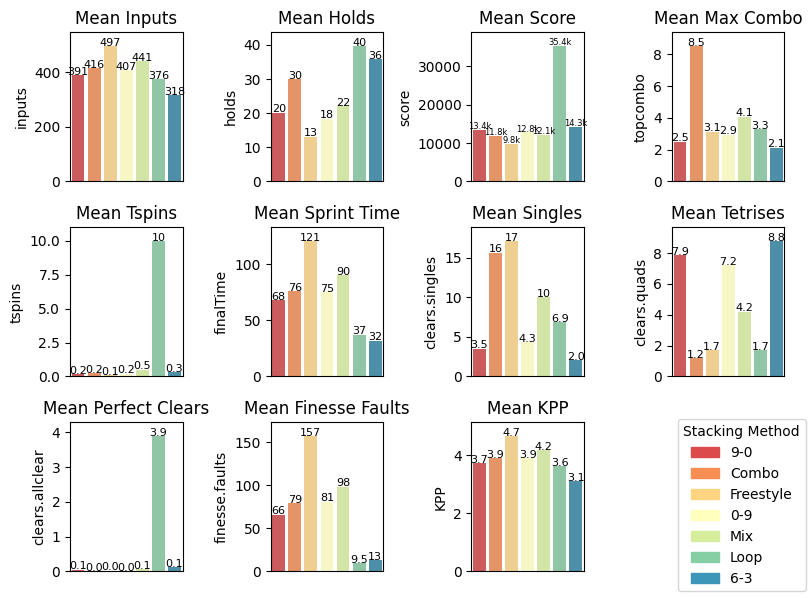

In [21]:
colors = sns.color_palette("Spectral", n_colors=len(group_df))

num_columns = 4
num_rows = -(-len(columns_to_plot) // num_columns) 
fig, axes = plt.subplots(num_rows, num_columns, figsize=(8, 2*num_rows)) 

for i, column in enumerate(columns_to_plot):
    row = i // num_columns  
    col = i % num_columns  
    ax = axes[row, col] if num_rows > 1 else axes[col] 
    sns.barplot(x=np.arange(len(group_df)), y=column, data=group_df, ax=ax, hue_order=stacking_methods, palette=colors)
    ax.set_title(f"Mean {columns_to_plot[column]}")
    ax.set_xticks([])

    max_height = group_df[column].max()
    ax.set_ylim(0, max_height + max_height * 0.1) 

    for p in ax.patches:
        if p.get_height()<10:
            ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()+max_height*.025),
                        ha='center', va='center', xytext=(0, 0), textcoords='offset points', fontsize=8)  
        elif p.get_height()<1000:
            ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()+max_height*.025),
                        ha='center', va='center', xytext=(0, 0), textcoords='offset points', fontsize=8) 
        else:
            ax.annotate('{:.1f}k'.format(p.get_height() / 1000), (p.get_x() + p.get_width() / 2., p.get_height()+max_height*.025),
                        ha='center', va='center', xytext=(0, 0), textcoords='offset points', fontsize=6) 

if len(columns_to_plot) < num_rows * num_columns:
    for j in range(len(columns_to_plot), num_rows * num_columns):
        fig.delaxes(axes.flatten()[j])

handles, labels = ax.get_legend_handles_labels()

handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(group_df))]
labels = group_df.index.tolist()

fig.legend(handles, labels, title='Stacking Method', loc='lower right')

plt.tight_layout() 
plt.show()


### Key Findings 
* 6-3 generally has lower input/kpp count as it is a more optimized stacking method
* Loop has the highest hold count as you're looking for tspins and perfect clears which requires more holding
* Freestyle requires less holding since you can rely on skims to get you out of most sitatuions
* Loop has by far the highest average score since Looping was made to optimize score 
* Combo has the highest max combo average as its the main way of clearing lines in that method
* Loop has by far highest average of Tspins and Perfect clears since most loops do both 
* 6-3 and Loop have the lowest average sprint time and finesse faults since they're higher skilled stacking methods 
* Combo and Freestyle have higher single clear averages as both methods rely on those types of clears
* 9-0, 0-9, and 6-3 have high tetris clear averages as they're all tetris stacking methods

**I now wanted to look at the distribution of stacking styles**

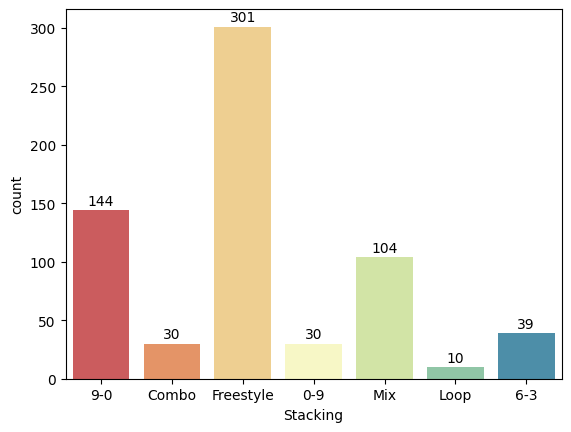

In [22]:
g = sns.countplot(data=df4, x="Stacking", palette=dict(zip(stacking_methods, colors)))

for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()-4), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

**Freestyle seems to be the far most popular with 9-0 and Mix being fairly used as well, but I want to also see how the styles are distributed based on rank**

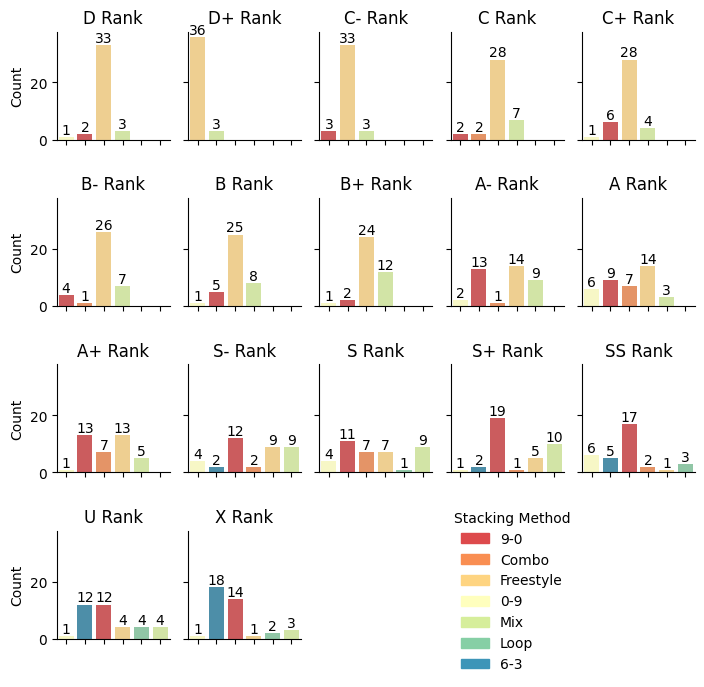

In [23]:
rank_order = ['d', 'd+', 'c-','c','c+','b-','b','b+','a-','a','a+','s-','s','s+','ss','u','x']

grouped_data = df4.groupby(['Rank', 'Stacking']).size().reset_index(name='Count')


g = sns.FacetGrid(grouped_data, col='Rank', col_wrap=5, height=1.75,col_order=rank_order)
g.map(sns.barplot, 'Stacking', 'Count', palette=dict(zip(stacking_methods, colors)))

for ax, rank in zip(g.axes.flat, rank_order):
    ax.set_title(f'{rank.upper()} Rank')
    ax.set_xticklabels([])
    ax.set_xlabel('')
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(stacking_methods))]
labels = stacking_methods
legend = plt.legend(handles, labels, title='Stacking Method',bbox_to_anchor=(3.5, 1.3))

legend.get_frame().set_linewidth(0) 
plt.subplots_adjust(right=0.8)  

plt.show()


### Key Findings
* Freestyle is used a lot more used by lower ranked players (D to B+ rank), likely do to the fact that they don't know how to properly stack yet
* As you get to the middle ranks (A- to S+ rank), you see a lot more 9-0 and comboing as players get better at stacking properly
* At the higher ranks (SS to X rank) you can see 6-3 and Loop starting to emerge as they're the stacking methods that require the most skill to master

**Mix1, Mix2, and Mix3 were columns that showed the different stacking styles for players that had a mix as their stacking methods. I attempted to do multi hot encoding and then multi label classification with these columns, but scrapped the idea as I was only able to get models with at most 70% accuracy, likely because the model struggled to distinguish stacking styles like 0-9,9-0, and 6-3. Since these 3 columns and the rank column are not needed for the training, they are dropped**

In [24]:
df5 = df4.drop(['Rank','Mix1','Mix2','Mix3'], axis=1)

<h2 style='color:blue'>Model Training</h2>

**Scaling the data with normalization so the model can better handle the differences in values** 

In [25]:
Scaler = StandardScaler()
X = pd.DataFrame(Scaler.fit_transform(df5.drop('Stacking',axis=1)))
y=df5['Stacking']

In [26]:
y.value_counts()

Stacking
Freestyle    301
9-0          144
Mix          104
6-3           39
Combo         30
0-9           30
Loop          10
Name: count, dtype: int64

**Since the distribution of stacking styles is not very even, the model might struggle to handle accurately classifying stacking styles with only a few runs.I'll be using SMOTE, an oversampling technique, to even out the dataset**

In [27]:
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)
y_resampled.value_counts()

Stacking
9-0          301
Combo        301
Freestyle    301
0-9          301
Mix          301
Loop         301
6-3          301
Name: count, dtype: int64

**Train Test spliting the data and testing several different models to find those that have high accuracy**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0,stratify=y_resampled)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

         0-9       0.92      0.99      0.95        91
         6-3       0.96      1.00      0.98        90
         9-0       0.90      0.78      0.83        90
       Combo       0.94      1.00      0.97        90
   Freestyle       0.94      0.87      0.90        91
        Loop       1.00      1.00      1.00        91
         Mix       0.79      0.81      0.80        90

    accuracy                           0.92       633
   macro avg       0.92      0.92      0.92       633
weighted avg       0.92      0.92      0.92       633

0.9210110584518167


**We can see a fairly high accuracy for Random Forest and the different stackings precision, recall, and f1-score, but I'll create a confusion matrix so we can visually it better** 

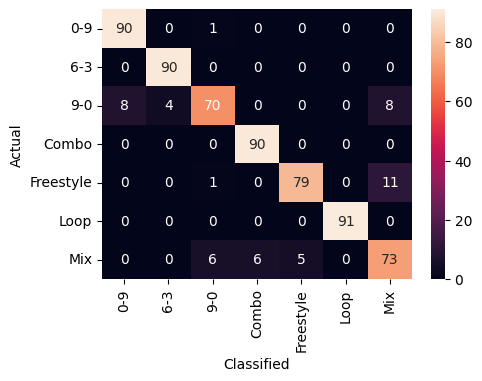

In [29]:
y_test_labels = np.unique(y_test)
y_pred_labels = np.unique(y_pred)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,3.5))
sns.heatmap(cm, annot=True, xticklabels=y_pred_labels, yticklabels=y_test_labels)
plt.xlabel('Classified')
plt.ylabel('Actual')

plt.show()

**Looking at the confusion matrix of the random forest model, we can see overall it is very accurate, but sometimes incorrectly classifies 9-0 sprints and often classifies Freestyle sprints as Mix sprints**  

**I tested several different models and found that Random Forest, Gradient Boost, and K neighbors models do the best around 90%, so I'll do some hyperparameter tuning on these models using ShuffleSplit and GridSearchCV** 

In [30]:
model_params =  {
        'random_forest' : {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators' : [100,500,1000],
                'criterion': ["gini", "entropy", "log_loss"]
            }
        },
        'gradient_boost': {
            'model': GradientBoostingClassifier(),
            'params': {
                'loss' : ['log_loss', 'deviance', 'exponential'],
                'n_estimators' : [100,500,1000]
            }
        },
        'k_neighbors': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors' : [3,5],
                 'algorithm' : ['auto', 'ball_tree', 'kd_tree']
            }
        }
    }
def gridsearchcv(X,y):
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in model_params.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_,
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

gridsearchcv(X_resampled,y_resampled)

,model,best_score,best_params
0,random_forest,0.924645,"{'criterion': 'log_loss', 'n_estimators': 1000}"
1,gradient_boost,0.906161,"{'loss': 'log_loss', 'n_estimators': 500}"
2,k_neighbors,0.900948,"{'algorithm': 'auto', 'n_neighbors': 3}"


In [31]:
RF_clf = RandomForestClassifier(criterion='gini', n_estimators=100)
RF_clf.fit(X_resampled,y_resampled)

RandomForestClassifier()

In [32]:
KN_clf = KNeighborsClassifier(n_neighbors=3, algorithm='auto')
KN_clf.fit(X_resampled,y_resampled)

KNeighborsClassifier(n_neighbors=3)

In [33]:
GB_clf = GradientBoostingClassifier(loss='log_loss', n_estimators=1000)
GB_clf.fit(X_resampled,y_resampled)

GradientBoostingClassifier(n_estimators=1000)

In [34]:
df5.head()

,lines,inputs,holds,score,combo,topcombo,btb,topbtb,tspins,piecesplaced,finalTime,clears.singles,clears.doubles,clears.triples,clears.quads,clears.realtspins,clears.minitspins,clears.minitspinsingles,clears.tspinsingles,clears.tspindoubles,clears.tspintriples,clears.allclear,finesse.combo,finesse.faults,finesse.perfectpieces,Stacking,KPP
0,40,408,23,12096,2,2,0,5,0,108,62.650000,11,1,1,6,0,0,0,0,0,0,0,0,74,67,9-0,3.777778
1,40,358,23,10802,1,6,0,1,0,102,79.260000,8,6,4,2,0,0,0,0,0,0,0,8,41,80,Combo,3.509804
2,40,353,3,9142,2,3,0,0,0,102,59.181667,18,8,2,0,0,0,0,0,0,0,0,1,56,70,Freestyle,3.460784
3,41,643,9,9111,1,3,0,0,0,107,104.233333,26,6,1,0,0,0,0,0,0,0,0,0,292,24,Freestyle,6.009346
4,40,441,27,12574,1,11,0,1,2,104,103.871667,20,9,0,0,0,0,2,0,0,0,0,0,101,58,Combo,4.240385


<h2 style='color:blue'>Testing the Models</h2>

**I created functions to compare the classication results for each model and used several top players' sprints. Credits to fortissim2 and their sheet for player reference https://docs.google.com/spreadsheets/d/1lfcOYz7ZIIwXl4XLKECpXba-noL_wrhWl8xG1KyFZDg/edit#gid=341372929**

In [35]:
def get_sprint_data(username):
    url = f"https://ch.tetr.io/api/users/{username.lower()}/records"
    response = requests.get(url)
    if response.status_code == 200:
        if not pd.DataFrame(response.json()['data']['records']['40l']['record']).empty:
            sprint_data = pd.json_normalize(response.json()['data']['records']['40l']['record']['endcontext'])
            return sprint_data, response.json()['data']['records']['40l']['record']['replayid']
        
def classify_sprint(username):
    try: 
        sprint_data, replay = get_sprint_data(username)
    except:
        print("User doesn't exist or does not have a sprint")
        return
    sprint_data2 = sprint_data.drop(['level_lines','level_lines_needed','zenlevel',
             'zenprogress','level','currentcombopower','kills',
             'time.start','time.prev','time.frameoffset','gametype',
             'clears.minitspindoubles','clears.tspinquads','garbage.sent',
             'garbage.received','garbage.attack','garbage.cleared','currentbtbchainpower','time.zero','time.locked','seed'],axis=1,errors='ignore')
    sprint_data2['KPP']=sprint_data2.inputs/sprint_data2.piecesplaced
    sprint_data2['finalTime'] = sprint_data2['finalTime']/1000
    if 'holds' not in sprint_data2.columns:
        sprint_data2.insert(2, 'holds', 0)
    sprint_data3 = Scaler.transform(sprint_data2)
    classification1 = RF_clf.predict(sprint_data3)[0]
    classification2 = KN_clf.predict(sprint_data3)[0]
    classification3 = GB_clf.predict(sprint_data3)[0]
    print('Random Forest Classification sprint pb is : ' + classification1)
    print('K Neighbors Classification sprint pb is : ' + classification2)
    print('Gradient Boost Classification sprint pb is : ' + classification3)
    print(f"https://tetr.io/#r:{replay}")

In [36]:
classify_sprint('blaarg') # Actual is 6-3

Random Forest Classification sprint pb is : 9-0
K Neighbors Classification sprint pb is : 6-3
Gradient Boost Classification sprint pb is : 9-0
https://tetr.io/#r:62ea03ca401ae720e6b5f287


In [37]:
classify_sprint('Rideris') # Actual is 9-0

Random Forest Classification sprint pb is : 9-0
K Neighbors Classification sprint pb is : 6-3
Gradient Boost Classification sprint pb is : 9-0
https://tetr.io/#r:64734dd8bcca5759983610a3


In [38]:
classify_sprint('fortissim2') # Actual is 6-3

Random Forest Classification sprint pb is : 9-0
K Neighbors Classification sprint pb is : 6-3
Gradient Boost Classification sprint pb is : 9-0
https://tetr.io/#r:63443cfd502118e7df3a8544


In [39]:
classify_sprint('fesh') # Actual is Loop

Random Forest Classification sprint pb is : Loop
K Neighbors Classification sprint pb is : Loop
Gradient Boost Classification sprint pb is : Loop
https://tetr.io/#r:63ab37074d1ec80965d08368


In [40]:
classify_sprint('westl') # Actual is Freestyle

Random Forest Classification sprint pb is : Freestyle
K Neighbors Classification sprint pb is : 6-3
Gradient Boost Classification sprint pb is : Freestyle
https://tetr.io/#r:647255a924b3898e74f1c96a


**K Neighbors was able to correctly classify players like fortissim and blaarg when the other two models couldn't but incorrectly classified Rideru and Westl or as well while the others got it correct. I'll go with Random Forest because while Gradient Boost did get the same classifications, it did have a slighly lower accuracy during the hyperparamter tuning** 

**Using Random Forest, we can look at the feature importance of certain variables to see which ones the model finds most useful in classifying sprints** 

In [44]:
importances = RF_clf.feature_importances_


indices = np.argsort(importances)[::-1]

print("Feature importance ranking:")
for i, idx in enumerate(indices):
    print(f"{i+1}. Feature {df5.drop('Stacking',axis=1).columns[idx]}: {importances[idx]}")

Feature importance ranking:
1. Feature score: 0.11110449289875954
2. Feature topcombo: 0.09319180893877844
3. Feature clears.quads: 0.09198197967569309
4. Feature topbtb: 0.0646336410643986
5. Feature holds: 0.06330655102252201
6. Feature finesse.perfectpieces: 0.060256561013116404
7. Feature finesse.faults: 0.05950963031552188
8. Feature clears.singles: 0.055810850814138654
9. Feature finalTime: 0.049501393924898586
10. Feature clears.doubles: 0.04665086302185391
11. Feature inputs: 0.039787421057977446
12. Feature clears.tspindoubles: 0.03691826294337977
13. Feature KPP: 0.03598479352413872
14. Feature clears.allclear: 0.03070724078058656
15. Feature piecesplaced: 0.03007713780203013
16. Feature tspins: 0.028036940957109294
17. Feature finesse.combo: 0.026517267157243358
18. Feature clears.triples: 0.02586897781758463
19. Feature combo: 0.014291012450862449
20. Feature btb: 0.011065231218180472
21. Feature clears.tspinsingles: 0.010435536717277047
22. Feature lines: 0.009008490303906

In [42]:
with open('sprint_classification_model.pickle','wb') as f:
    pickle.dump(RF_clf,f)
with open('data_scaler.pickle','wb') as f:
    pickle.dump(Scaler,f)